<a href="https://colab.research.google.com/github/angelmorales2621-gif/simulaci-n2/blob/main/metropolis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Visualizando la distribución objetivo...


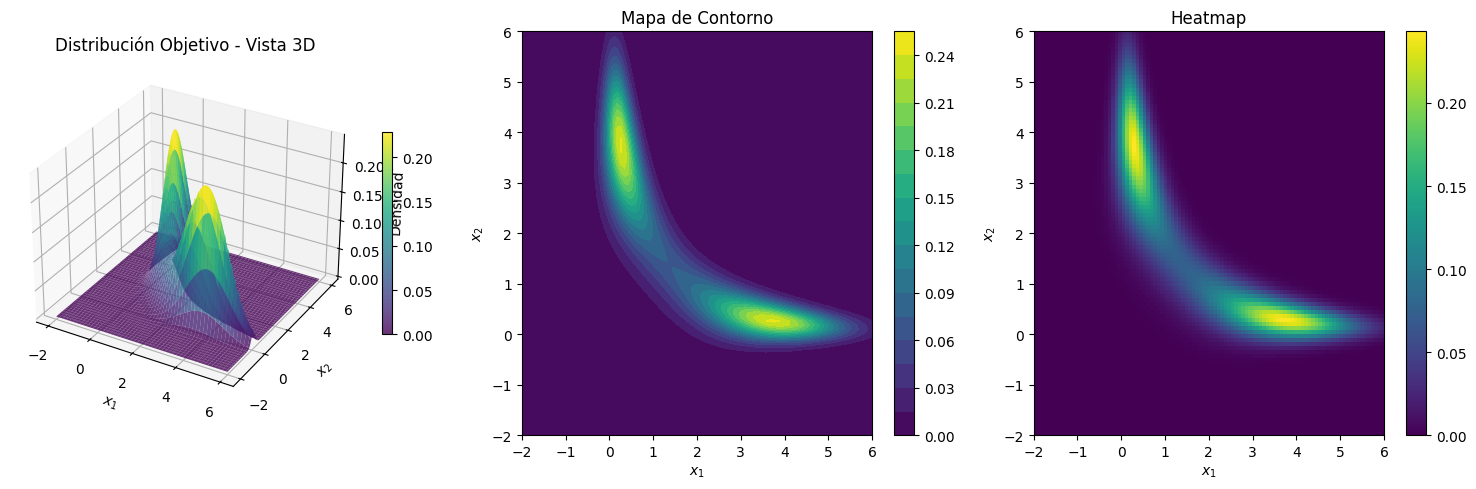

Generando 10000 muestras...
Tasa de aceptación: 0.240
Muestras generadas: (10000, 2)
Media de las muestras: x1 = 1.862, x2 = 1.868
Desviación estándar: x1 = 1.668, x2 = 1.670

Visualizando resultados del MCMC...


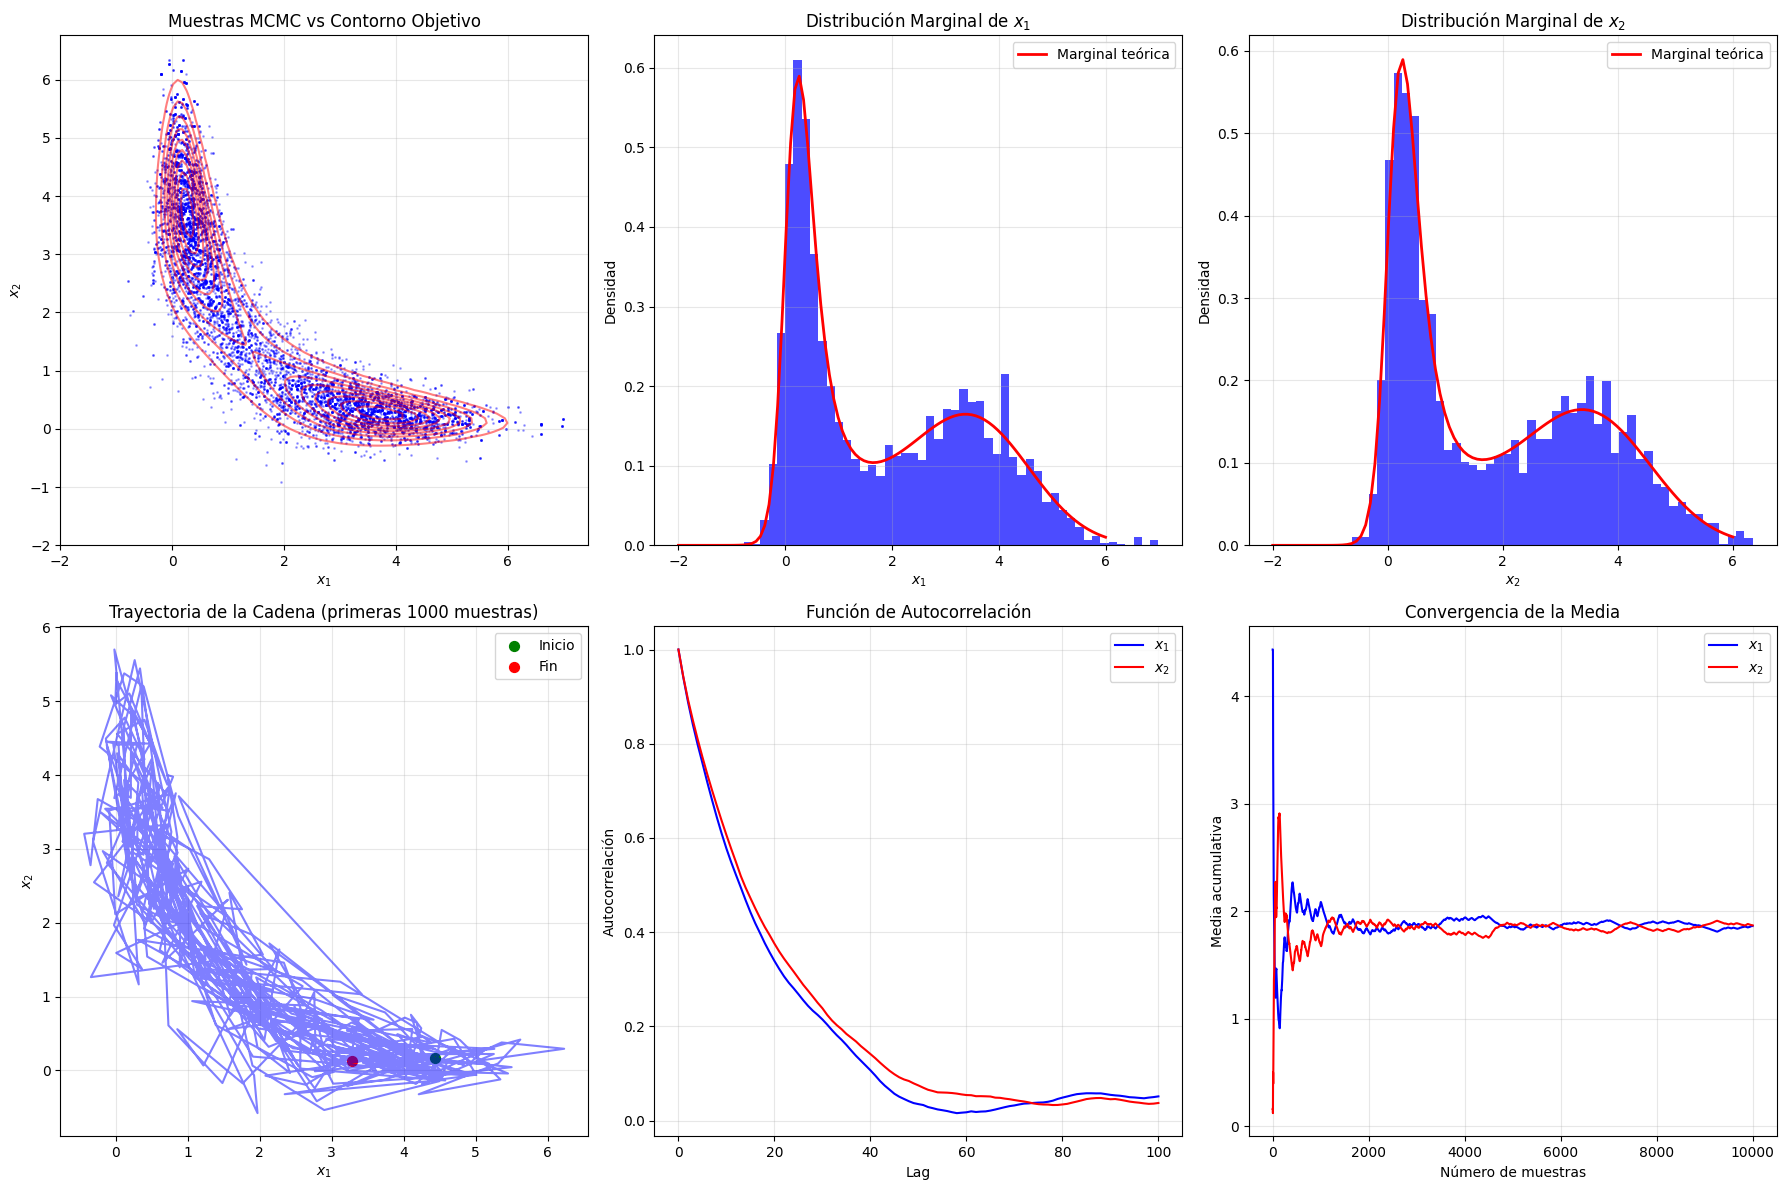

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from typing import Tuple

class MetropolisHastings2D:

    def __init__(self, target_log_prob: callable, proposal_cov: np.ndarray = None):

        self.target_log_prob = target_log_prob

        if proposal_cov is None:
            self.proposal_cov = np.eye(2) * 2.0  # Covarianza por defecto
        else:
            self.proposal_cov = proposal_cov

    def sample(self, n_samples: int, initial_state: np.ndarray = None,
               burn_in: int = 1000, thin: int = 1) -> np.ndarray:

        if initial_state is None:
            initial_state = np.array([0.0, 0.0])

        total_samples = n_samples * thin + burn_in
        samples = np.zeros((total_samples, 2))
        samples[0] = initial_state
        accepted = 0

        for i in range(1, total_samples):
            current_state = samples[i-1]

            # Generar candidato desde distribución propuesta (Normal multivariada)
            candidate = np.random.multivariate_normal(current_state, self.proposal_cov)

            # Calcular ratio de aceptación en espacio logarítmico
            current_log_prob = self.target_log_prob(current_state)
            candidate_log_prob = self.target_log_prob(candidate)

            log_acceptance_ratio = candidate_log_prob - current_log_prob
            acceptance_ratio = min(0, log_acceptance_ratio)  # En espacio log

            # Aceptar o rechazar el candidato
            if np.log(np.random.uniform(0, 1)) < acceptance_ratio:
                samples[i] = candidate
                accepted += 1
            else:
                samples[i] = current_state

        # Calcular tasa de aceptación
        acceptance_rate = accepted / total_samples
        print(f"Tasa de aceptación: {acceptance_rate:.3f}")

        # Aplicar burn-in y thinning
        samples_burned = samples[burn_in:]
        if thin > 1:
            samples_thinned = samples_burned[::thin]
        else:
            samples_thinned = samples_burned

        return samples_thinned[:n_samples]

# distribución objetivo
def target_log_probability(x):
    x1, x2 = x
    exponent = -(x1**2 * x2**2 + x1**2 + x2**2 - 8*x1 - 8*x2) / 2
    return exponent

def target_density(x1, x2):
    """
    Densidad objetivo con constante de normalización aproximada
    """
    c = 1/20216.335877  # Constante de normalización dada
    exponent = -(x1**2 * x2**2 + x1**2 + x2**2 - 8*x1 - 8*x2) / 2
    return c * np.exp(exponent)

# Función para visualizar la distribución objetivo y las muestras
def plot_target_density():
    """Visualizar la distribución objetivo en 3D"""
    x1 = np.linspace(-2, 6, 100)
    x2 = np.linspace(-2, 6, 100)
    X1, X2 = np.meshgrid(x1, x2)

    Z = target_density(X1, X2)

    fig = plt.figure(figsize=(15, 5))

    # Gráfica 3D
    ax1 = fig.add_subplot(131, projection='3d')
    surf = ax1.plot_surface(X1, X2, Z, cmap='viridis', alpha=0.8)
    ax1.set_xlabel('$x_1$')
    ax1.set_ylabel('$x_2$')
    ax1.set_zlabel('Densidad')
    ax1.set_title('Distribución Objetivo - Vista 3D')
    plt.colorbar(surf, ax=ax1, shrink=0.5)

    # Contorno
    ax2 = fig.add_subplot(132)
    contour = ax2.contourf(X1, X2, Z, levels=20, cmap='viridis')
    ax2.set_xlabel('$x_1$')
    ax2.set_ylabel('$x_2$')
    ax2.set_title('Mapa de Contorno')
    plt.colorbar(contour, ax=ax2)

    # Heatmap
    ax3 = fig.add_subplot(133)
    im = ax3.imshow(Z, extent=[x1.min(), x1.max(), x2.min(), x2.max()],
                   origin='lower', cmap='viridis', aspect='auto')
    ax3.set_xlabel('$x_1$')
    ax3.set_ylabel('$x_2$')
    ax3.set_title('Heatmap')
    plt.colorbar(im, ax=ax3)

    plt.tight_layout()
    plt.show()

def plot_mcmc_results(samples, target_density):
    """Visualizar resultados del MCMC"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Dispersión de las muestras con contorno
    x1_range = np.linspace(-2, 6, 100)
    x2_range = np.linspace(-2, 6, 100)
    X1, X2 = np.meshgrid(x1_range, x2_range)
    Z = target_density(X1, X2)

    axes[0, 0].contour(X1, X2, Z, levels=10, colors='red', alpha=0.5)
    axes[0, 0].scatter(samples[:, 0], samples[:, 1], alpha=0.3, s=1, color='blue')
    axes[0, 0].set_xlabel('$x_1$')
    axes[0, 0].set_ylabel('$x_2$')
    axes[0, 0].set_title('Muestras MCMC vs Contorno Objetivo')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Histograma marginal para x1
    axes[0, 1].hist(samples[:, 0], bins=50, density=True, alpha=0.7, color='blue')
    x1_marginal = np.array([integrate.quad(lambda x2: target_density(x1, x2), -10, 10)[0]
                           for x1 in x1_range])
    axes[0, 1].plot(x1_range, x1_marginal, 'r-', linewidth=2, label='Marginal teórica')
    axes[0, 1].set_xlabel('$x_1$')
    axes[0, 1].set_ylabel('Densidad')
    axes[0, 1].set_title('Distribución Marginal de $x_1$')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Histograma marginal para x2
    axes[0, 2].hist(samples[:, 1], bins=50, density=True, alpha=0.7, color='blue')
    x2_marginal = np.array([integrate.quad(lambda x1: target_density(x1, x2), -10, 10)[0]
                           for x2 in x2_range])
    axes[0, 2].plot(x2_range, x2_marginal, 'r-', linewidth=2, label='Marginal teórica')
    axes[0, 2].set_xlabel('$x_2$')
    axes[0, 2].set_ylabel('Densidad')
    axes[0, 2].set_title('Distribución Marginal de $x_2$')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Trayectoria de la cadena (primeras 1000 muestras)
    axes[1, 0].plot(samples[:1000, 0], samples[:1000, 1], 'b-', alpha=0.5)
    axes[1, 0].scatter(samples[0, 0], samples[0, 1], color='green', s=50, label='Inicio')
    axes[1, 0].scatter(samples[999, 0], samples[999, 1], color='red', s=50, label='Fin')
    axes[1, 0].set_xlabel('$x_1$')
    axes[1, 0].set_ylabel('$x_2$')
    axes[1, 0].set_title('Trayectoria de la Cadena (primeras 1000 muestras)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Autocorrelación para x1
    from statsmodels.tsa.stattools import acf
    autocorr_x1 = acf(samples[:, 0], nlags=100)
    axes[1, 1].plot(autocorr_x1, 'b-', label='$x_1$')
    autocorr_x2 = acf(samples[:, 1], nlags=100)
    axes[1, 1].plot(autocorr_x2, 'r-', label='$x_2$')
    axes[1, 1].set_xlabel('Lag')
    axes[1, 1].set_ylabel('Autocorrelación')
    axes[1, 1].set_title('Función de Autocorrelación')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Convergencia - media acumulativa
    cumulative_mean_x1 = np.cumsum(samples[:, 0]) / np.arange(1, len(samples) + 1)
    cumulative_mean_x2 = np.cumsum(samples[:, 1]) / np.arange(1, len(samples) + 1)

    axes[1, 2].plot(cumulative_mean_x1, 'b-', label='$x_1$')
    axes[1, 2].plot(cumulative_mean_x2, 'r-', label='$x_2$')
    axes[1, 2].set_xlabel('Número de muestras')
    axes[1, 2].set_ylabel('Media acumulativa')
    axes[1, 2].set_title('Convergencia de la Media')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Ejecutar el algoritmo
def main():
    print("Visualizando la distribución objetivo...")
    plot_target_density()

    # Parámetros del MCMC
    n_samples = 10000
    burn_in = 2000
    thin = 2

    # Crear instancia del sampler
    # Ajustar la covarianza de la propuesta para mejor eficiencia
    proposal_cov = np.array([[1.5, 0.2], [0.2, 1.5]])
    mh_sampler = MetropolisHastings2D(target_log_probability, proposal_cov)

    print(f"Generando {n_samples} muestras...")
    samples = mh_sampler.sample(n_samples=n_samples,
                               initial_state=np.array([2.0, 2.0]),
                               burn_in=burn_in,
                               thin=thin)

    print(f"Muestras generadas: {samples.shape}")
    print(f"Media de las muestras: x1 = {np.mean(samples[:, 0]):.3f}, x2 = {np.mean(samples[:, 1]):.3f}")
    print(f"Desviación estándar: x1 = {np.std(samples[:, 0]):.3f}, x2 = {np.std(samples[:, 1]):.3f}")

    print("\nVisualizando resultados del MCMC...")
    plot_mcmc_results(samples, target_density)

    return samples

if __name__ == "__main__":
    samples = main()